### Dataset Information
UrbanSound is an audio classification dataset containing 10 classes in total, represented by real-value numbers as such:
{0: 'air_conditioner', 
1: 'car_horn', 
2: 'children_playing', 
3: 'dog_bark', 
4: 'drilling', 
5:'engine_idling',
6: 'gun_shot', 
7:'jackhammer',
 8: 'siren', 
 9: 'street_music'}

Each audio is of variable length. The training and testing datasets have 1700 and 800 audio samples respectively, with class names randomly distributed and not equally represented. Class names are mentioned in the audio file names.

The dataset indicates that there are some misclassifications in the dataset, to provide general noise which must be accounted for.

Project available at https://github.com/jasonmatthewsuhari/IT1244_UrbanSound


### Part I: Preparing Dependencies
This section goes over the external libraries that we will be using.

##### 1.1 - Installing Dependencies

##### 1.2 - Loading Dependencies

In [49]:
import os
import scipy
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import IPython.display as ipd # ref. online, to play audio
import librosa # converge signals from stereo to mono, represent an audio signal wrt to a normalised pattern (-1 to 1), converts/standardises sample rate
import librosa.display
from scipy.io import wavfile as wav

### Part II: Loading the Dataset
This section goes over how we load the dataset through Google Drive (tentative to change based on submission format), and also some minor debugging practices to manually check for any misclassifications.

The dataset itself is locally available, but it is best for us to read the dataset from a Google Drive for storage efficiency. For the initial setup of this notebook, we will be using the locally available data to avoid using GDrive API calls.

In [136]:
CLIENT_SECRET_FILE = 'client_secret.json'
API_NAME = 'drive'
API_VERSION = 'v3'
SCOPES = ['https://www.googleapis.com/auth/drive']

service = Create_Service(CLIENT_SECRET_FILE, API_NAME, API_VERSION, SCOPES)

In [ ]:
# if secret exposed on github, just push. it's a test oauth id
path_id = "178Hn4bAcib8DnlBjjCI2S_jVRD0ytktl"
query_str = f"parents = '{path_id}'"

response = service.files().list(q=query_str).execute()
files = response.get('files')
nextPageToken = response.get('nextPageToken')

while(nextPageToken != None):
    response = service.files().list(q=query_str).execute()
    nextPageToken = response.get('nextPageToken')

df = pd.DataFrame(files)
print(df['name'])

In [137]:
# demonstration of audio player
# will be converted to spectrogram, but this can be used to check for any misclass
ipd.Audio('data/Train/Train_1__dog_bark.wav')

### Part III: Exploratory Data Analysis

##### Training data distribution

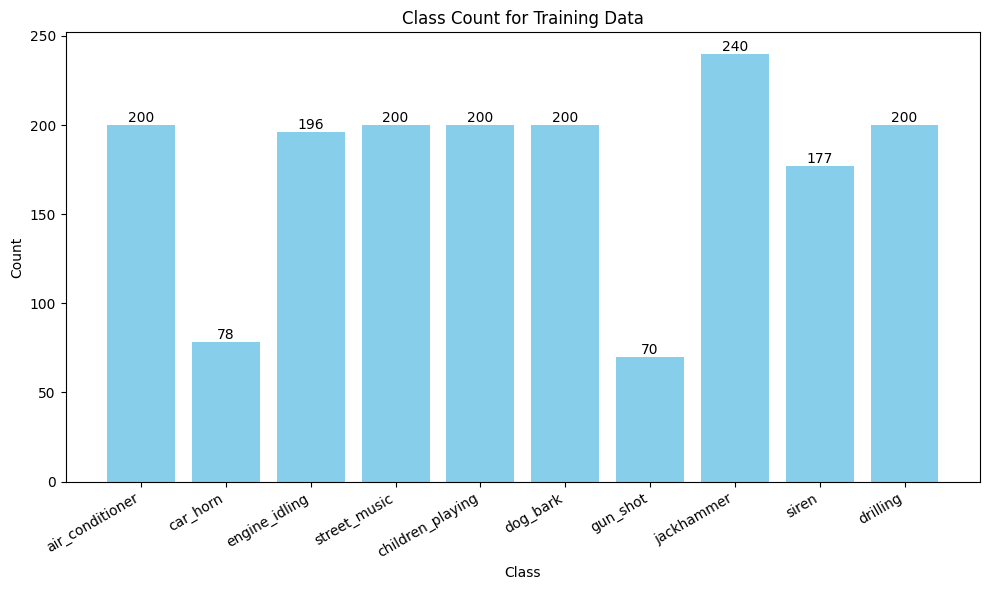

In [50]:
 # Check how imbalanced training data is
train_data_path = os.listdir('data/Train')
class_count = {}
for data in train_data_path:
    class_name = data.split('__')[1].split('.')[0]
    class_count[class_name] = class_count.get(class_name, 0) + 1

# Training data distribution graph
classes = class_count.keys()
counts = class_count.values()
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color='skyblue')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Count for Training Data')
plt.xticks(rotation=30, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Training data seems to be sufficiently balanced?

##### Waveform plots for each class

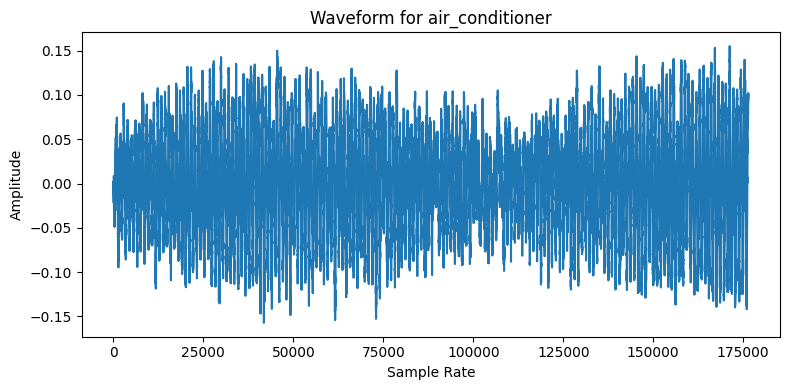

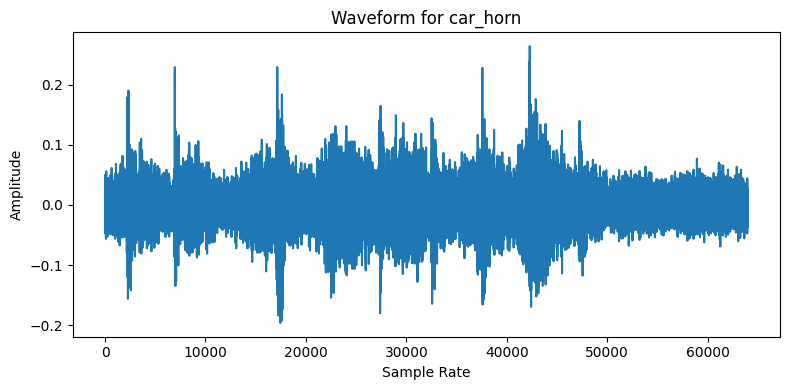

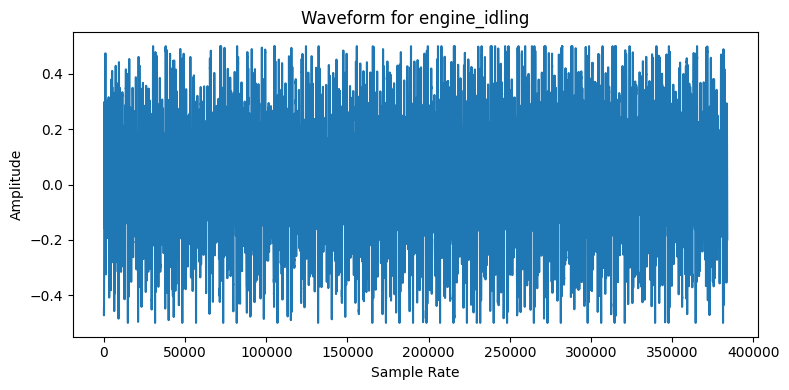

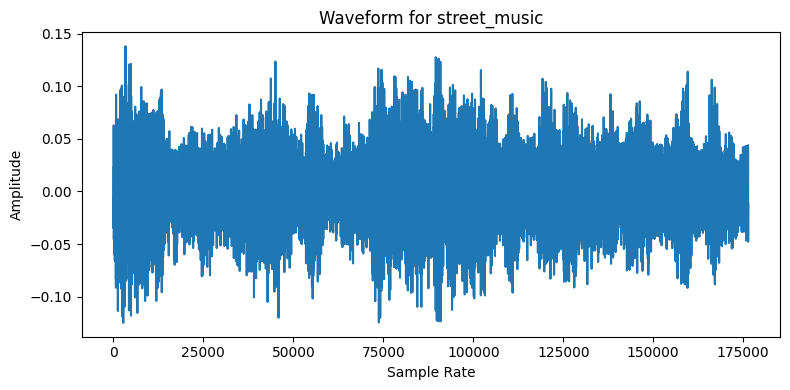

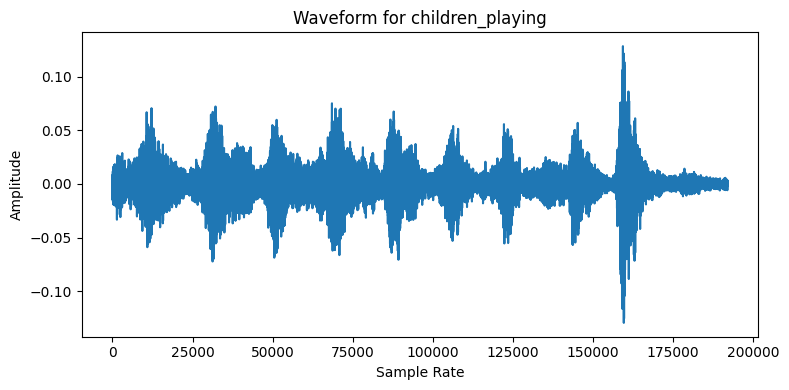

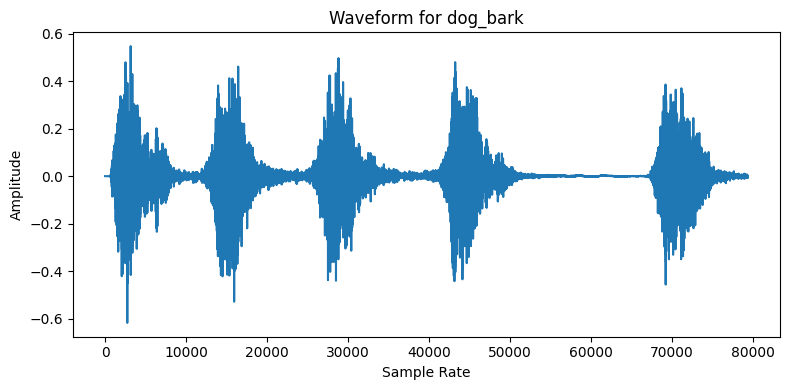

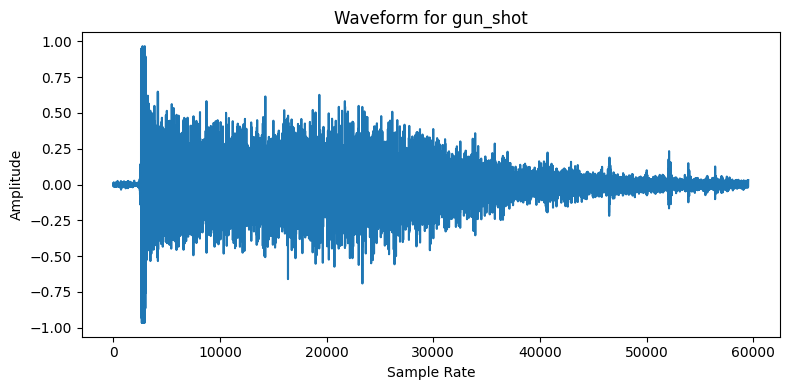

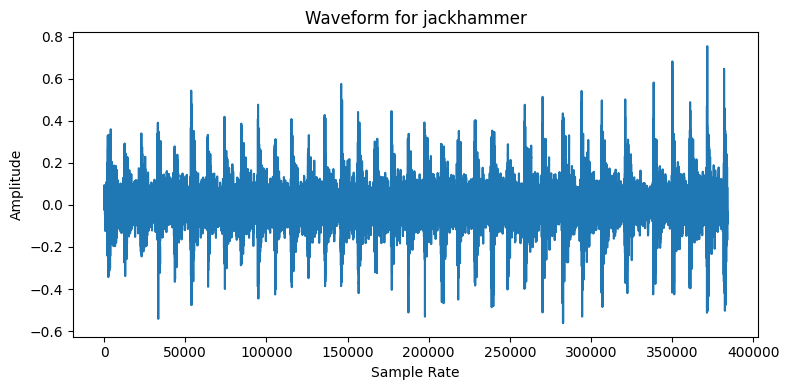

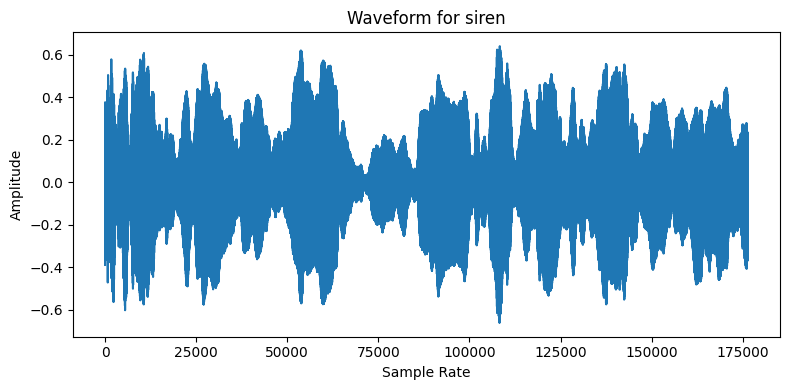

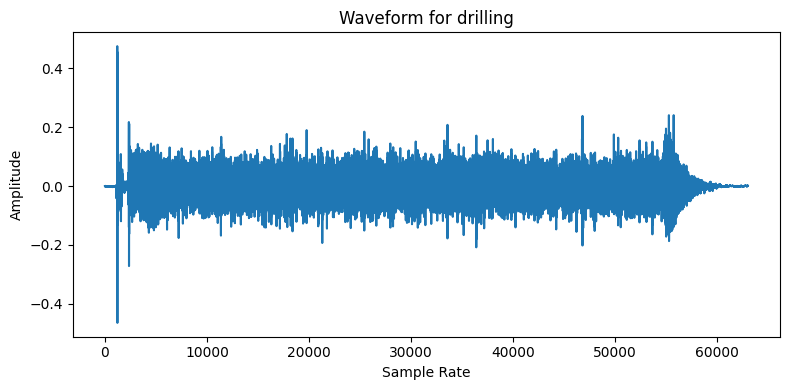

In [52]:

# Function to plot waveplot for a random audio sample in a class
def plot_waveform_for_class(class_name, files):
    plt.figure(figsize=(8, 4))
    plt.title(f'Waveform for {class_name}')
    
    # Choose a random file
    file = np.random.choice(files)
    
    # Load audio file
    audio_path = os.path.join('data/Train', file)
    waveform, sr = librosa.load(audio_path, sr=None)
    
    # Plot waveform
    plt.plot(waveform)
    plt.xlabel('Sample Rate')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Plot waveform for each class
for class_name in class_count.keys():
    # Get all files belonging to this class
    files = [file for file in train_data_path if class_name in file]
    # Plot waveform for this class
    plot_waveform_for_class(class_name, files)

##### Mono vs Stereo

[-5.8447593e-05  2.6010872e-05  3.4782410e-05 ...  2.2518770e-03
  2.8028022e-03  4.6307845e-03]
[[-20  14]
 [-18  16]
 [-16  19]
 ...
 [ 74 172]
 [116 185]
 [151 134]]


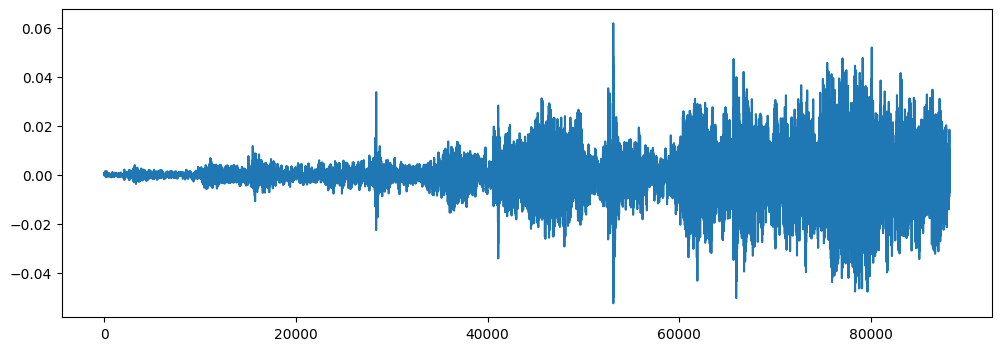

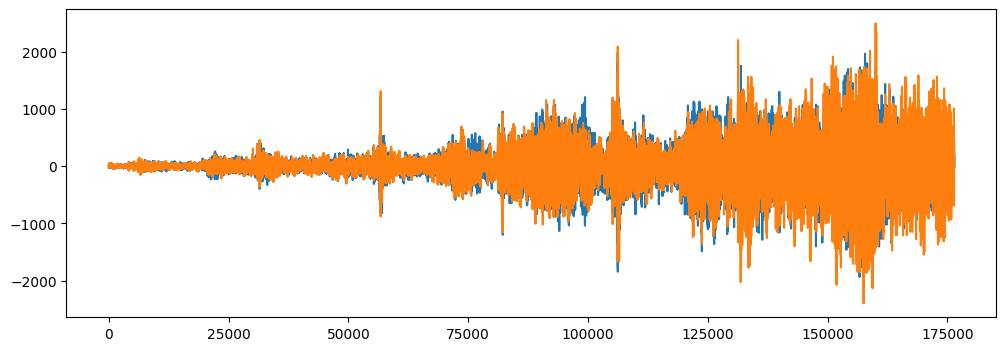

In [53]:
# Graphs for mono and stereo
audio_file_path = 'data/Train/Train_1544__street_music.wav'
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)
print(librosa_audio_data) # mono

# Original audio with 1 channel (mono)
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

wave_sample_rate, wave_audio = wav.read(audio_file_path)
print(wave_audio) # stereo

# Original audio with 2 channels (stereo)
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

##### Plot Sound Properties of Dataset

In [44]:
import soundfile as sf
import os
import matplotlib.pyplot as plt
from collections import Counter
# to move to top later

In [54]:
# for locally stored dataset - TODO find out how to use the google drive API
def extract_properties(filepath):
    """Use sound file library to cheaply extract properties of audio file.
    
    Parameters
        filepath (str): Path of an audio file."""
    try:
        with sf.SoundFile(filepath) as f:
            properties = {
                'samplerate' : f.samplerate,
                'channels' : f.channels,
                'subtype' : f.subtype,
                'duration' : len(f) / f.samplerate
            }
        return properties
    
    except Exception as e:
        print(f"Error: {e}")
        return None
    
def scan_dataset(directory):
    """Scan a directory for audio files and extract properties of each file.
    
    Parameters
        directory (str): Path of a directory containing audio files."""
    properties = []
    for file in os.listdir(directory):
        if file.endswith('.wav'):
            filepath = os.path.join(directory, file)
            file_properties = extract_properties(filepath)
            if file_properties:
                file_properties['filename'] = file
                properties.append(file_properties)
    return properties


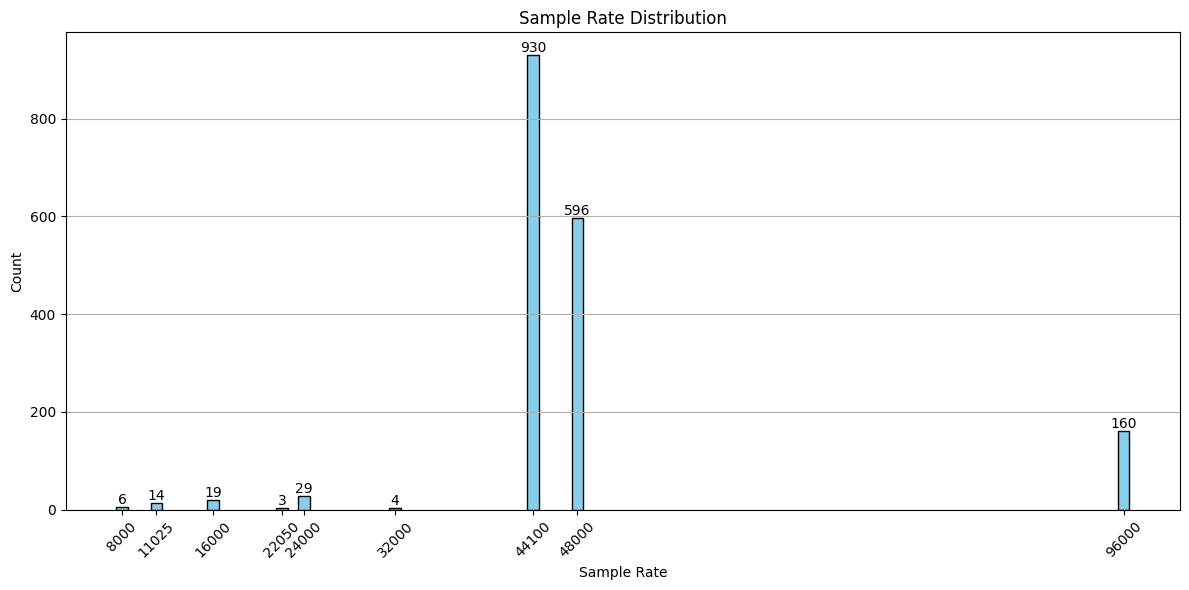

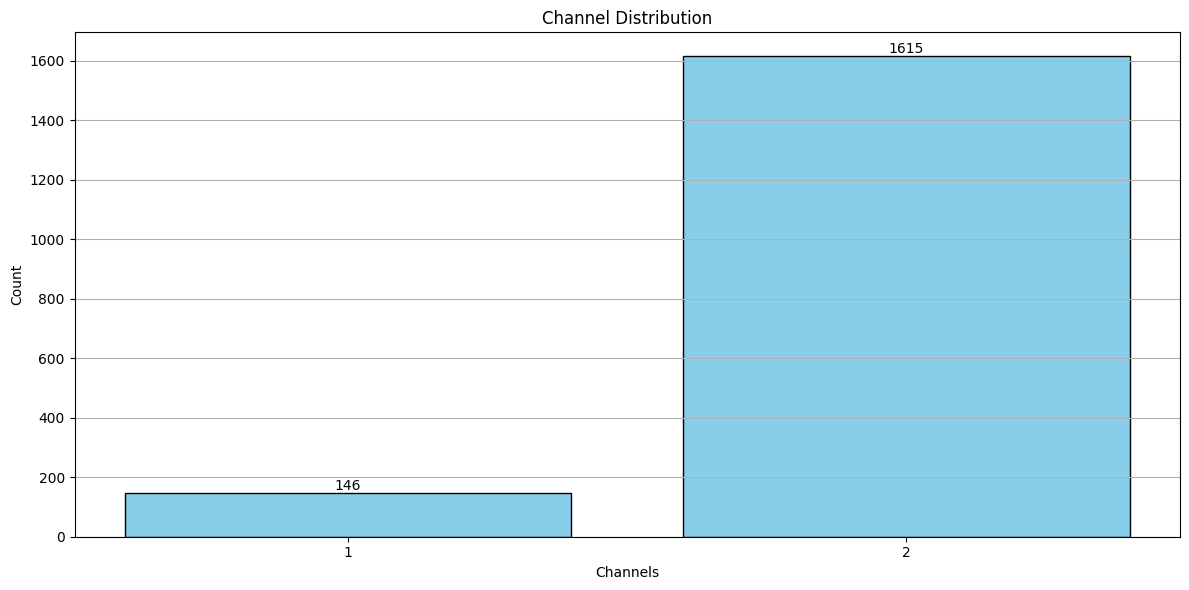

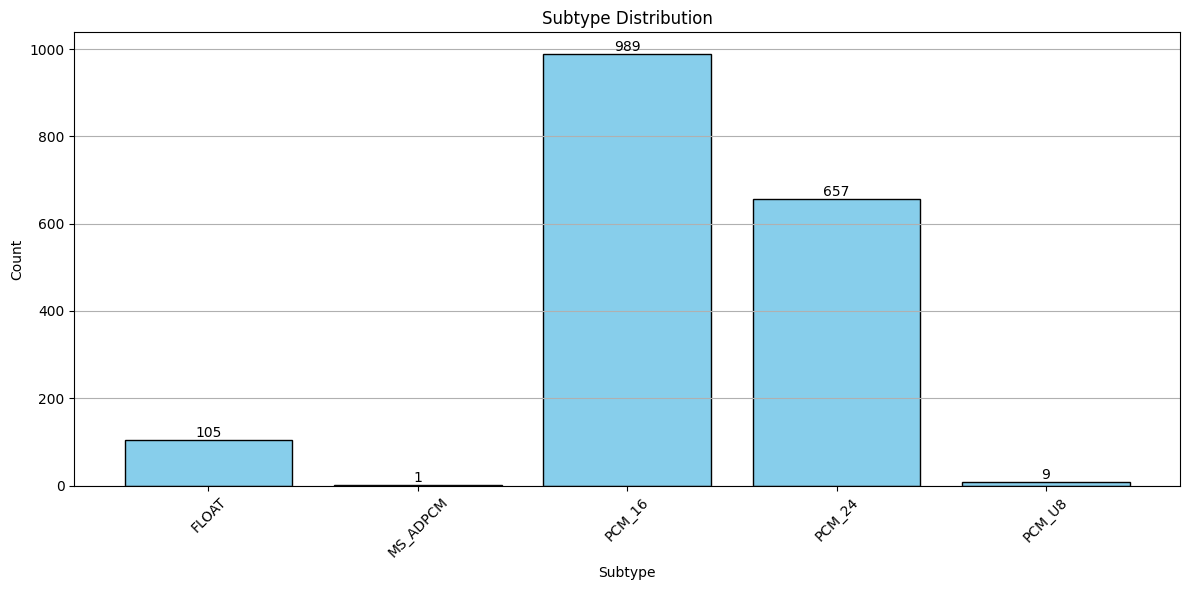

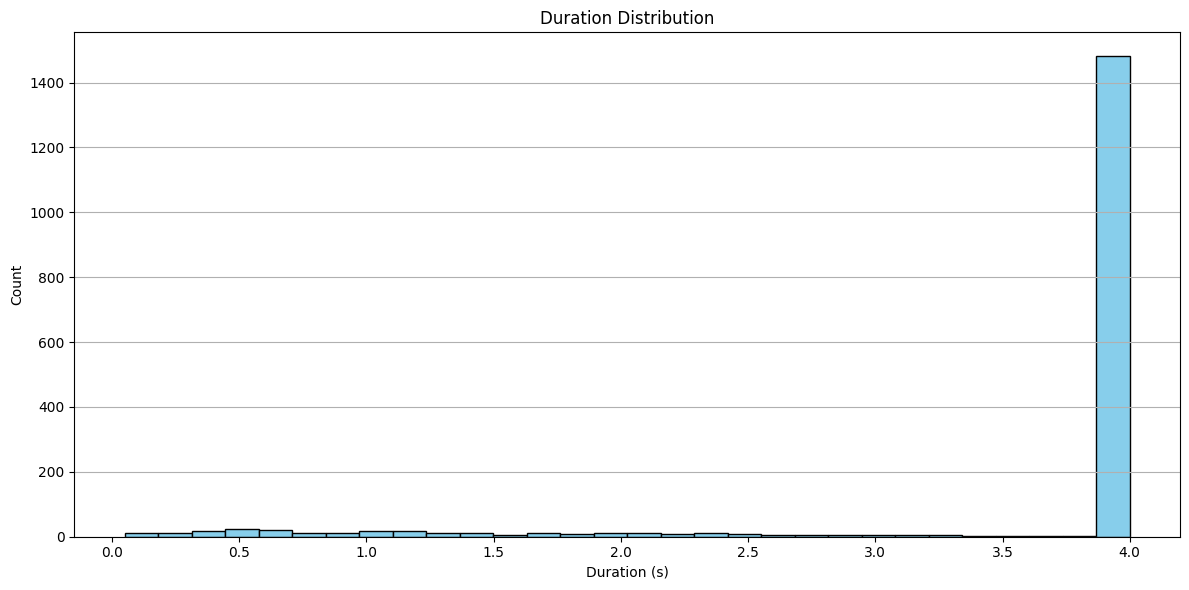

In [55]:
# Get properties of all audio files in the training dataset
train_properties = scan_dataset('data/Train')

def plot_audio_properties(property, title, xlabel, rotation=0):
    """Plot a bar graph of the chosen property.

    Parameters
        property (list): List of properties to plot.
        title (str): Title of the graph.
        xlabel (str): Label for the x-axis.
        rotation (int): Rotation of x-axis labels."""
    # Count, sort the property
    count = Counter(property)
    sorted_keys = sorted(count.keys())
    sorted_values = [count[key] for key in sorted_keys]

    # Plot the property
    plt.figure(figsize=(12, 6))
    if property == sr:
        plt.bar(sorted_keys, sorted_values, width=1000, color='skyblue', edgecolor='black')
    else:
        plt.bar(sorted_keys, sorted_values, color='skyblue', edgecolor='black')
        
    for bar, value in zip(sorted_keys, sorted_values):
        plt.text(bar, value, str(value), ha='center', va='bottom')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    if rotation:
        plt.xticks(sorted_keys, rotation=rotation)
    else: # to get integer x-axis labels
        plt.xticks(sorted_keys)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

def plot_duration(durations):
    """Plot a histogram of the duration of audio files.
    
    Parameters
        durations (list): List of durations of audio files."""
    plt.figure(figsize=(12, 6))
    plt.hist(durations, bins=30, color='skyblue', edgecolor='black')
    plt.title('Duration Distribution')
    plt.xlabel('Duration (s)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

# Separate properties
sr = [prop['samplerate'] for prop in train_properties]
ch = [prop['channels'] for prop in train_properties]
st = [prop['subtype'] for prop in train_properties]
duration = [prop['duration'] for prop in train_properties]

# Plot properties
plot_audio_properties(sr, 'Sample Rate Distribution', 'Sample Rate', rotation=45)
plot_audio_properties(ch, 'Channel Distribution', 'Channels')
plot_audio_properties(st, 'Subtype Distribution', 'Subtype', rotation=45)
plot_duration(duration)

##### Data Preprocessing

In [59]:
def convert_file(filepath, sr=44100, ch=2, duration=4):
    """Preprocess an audio file by converting it to mono, resampling, and trimming/padding"""
    # note: librosa converts to PCM_32 by default
    try:
        # Load audio
        audio, sr = librosa.load(filepath, sr=sr, mono=False)

        # If mono, convert to stereo
        if audio.ndim == 1:
            audio = np.repeat(audio.reshape(1, -1), ch, axis=0)

        # Pad or trim audio to desired duration
        target_samples = int(sr * duration)
        if len(audio.T) < target_samples:
            # Pad with zeros
            padding = target_samples - len(audio.T)
            audio = np.pad(audio, ((0, 0), (0, padding)), mode='constant')
        else:
            # Trim to 4s
            audio = audio[:, :target_samples]

        return audio, sr

    except Exception as e:
        print(f"Error: {e}")
        return None, None

def convert_dataset(directory):
    """Preprocess all audio files in a directory."""
    preprocessed_data = []
    for file in os.listdir(directory):
        if file.endswith('.wav'):
            filepath = os.path.join(directory, file)
            audio, sr = convert_file(filepath)
            if audio is not None:
                preprocessed_data.append(audio)

    return preprocessed_data

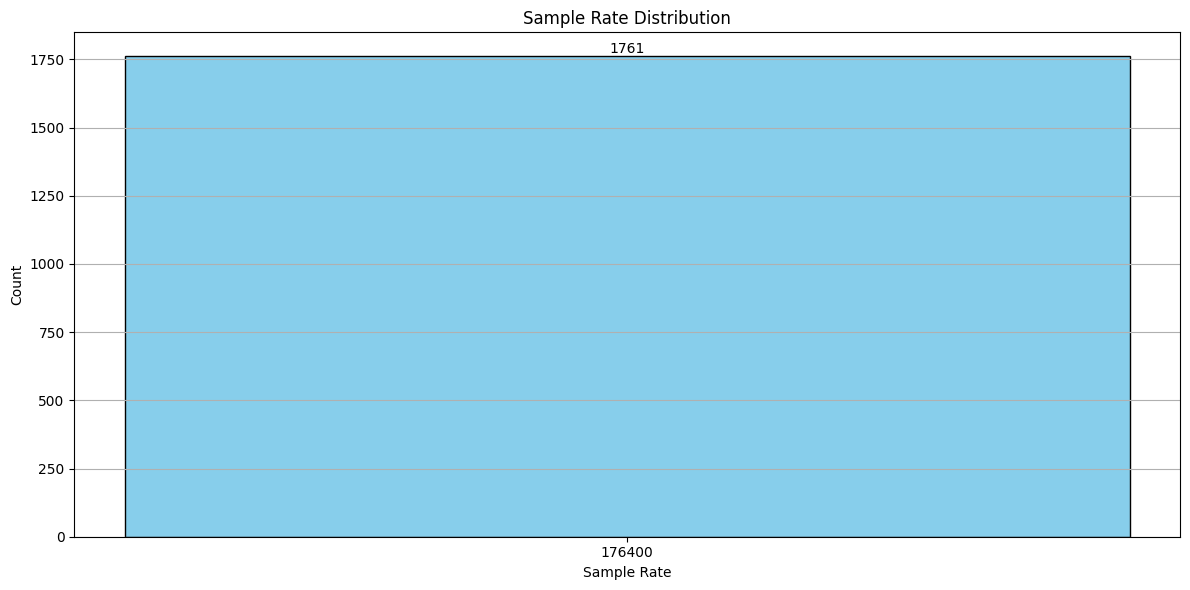

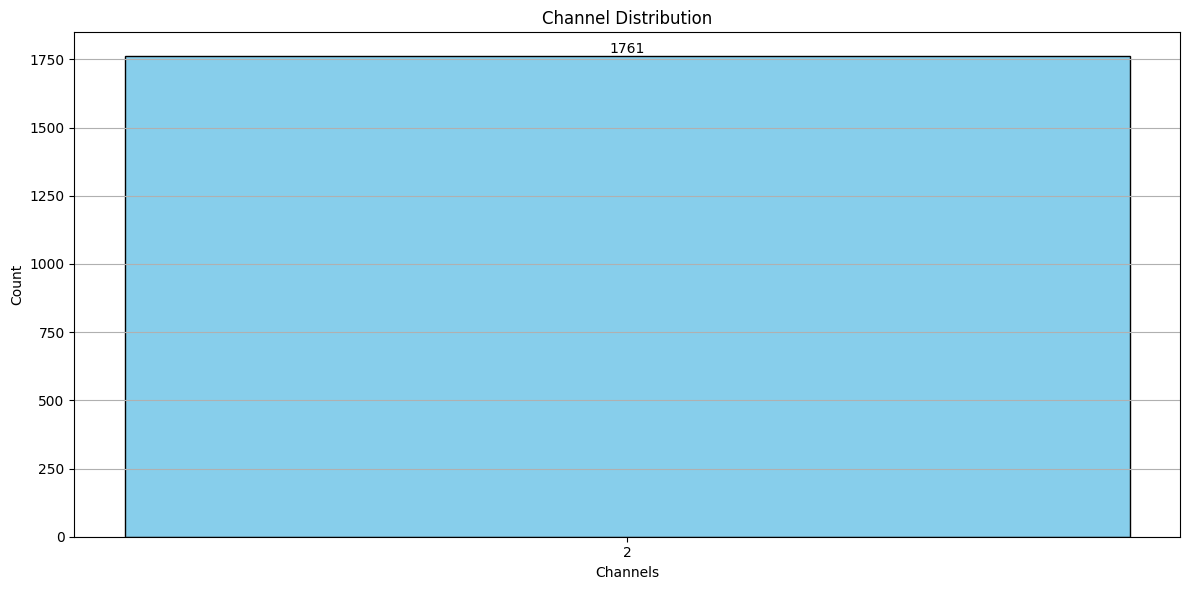

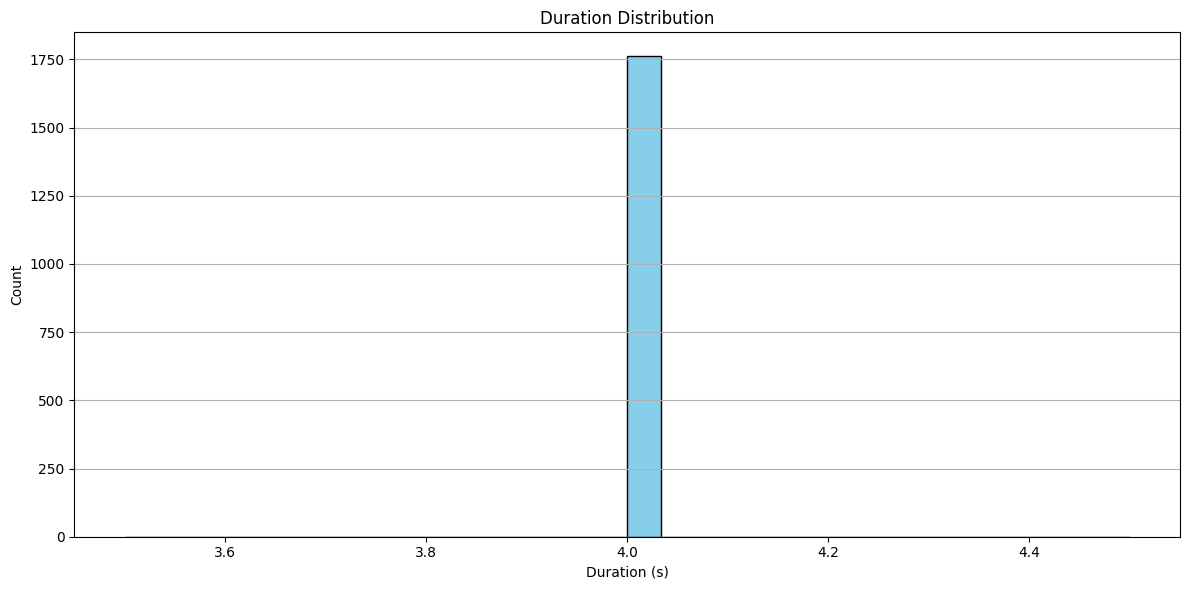

In [60]:
# Preprocess training data (if you want to check the preprocessed data)
train_data = convert_dataset('data/Train')

# plot the sr, ch, st, duration of preprocessed data
def plot_preprocessed_properties(data):
    """Plot properties of preprocessed audio data."""
    sr = [audio.shape[1] for audio in data]
    ch = [audio.shape[0] for audio in data]
    duration = [audio.shape[1] / 44100 for audio in data]

    plot_audio_properties(sr, 'Sample Rate Distribution', 'Sample Rate')
    plot_audio_properties(ch, 'Channel Distribution', 'Channels')
    plot_duration(duration)

plot_preprocessed_properties(train_data)

##### Extracting Features: Mel-Frequency Cepstral Coefficients (MFCC)

In [157]:
# MFCC for one sample file
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)
mfccs

def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

# MFCC for every training file

(40, 173)


### Part IV: Audio Classification Model

### Part V: Model Testing and Evaluation

### Part VI: Model Tuning